In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import yaml

from analysis.database import get_config

In [2]:
config = get_config()

df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from pathlib import Path

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_05"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

Creating directory: ../figures/0_3_0/analysis_05


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")

In [5]:
from Bio.SeqUtils import seq1
import re
from hgvs.sequencevariant import SequenceVariant
from hgvs.parser import Parser


In [6]:
hgvs_aa3 = set(
    "Ala Cys Asp Glu Phe Gly His Ile Lys Leu Met Asn Pro Gln Arg Ser Thr Val Trp Tyr Asx Glx Xaa Sec".split()
) | {"Ter"}

parser = Parser()


def to_aa1(
        sequence_variant: SequenceVariant
):
    # hgvs python package gives the AA3 code by default in the
    # str(variant.posedit) - use regex and convert all to 1 letter code
    posedit_str = str(sequence_variant.posedit)

    # strip out any parentheses
    posedit_str = posedit_str.replace("(", "").replace(")", "")

    # remove all non A-Za-z characters with regex
    aa3_codes = re.findall("[A-Z][a-z]{2}", posedit_str)

    # Convert each 3-letter code to a 1-letter code and replace it in the string
    for aa3 in aa3_codes:
        if aa3 not in hgvs_aa3:
            raise ValueError(f"Invalid AA3 code: {aa3}")
        aa1 = seq1(aa3)
        posedit_str = posedit_str.replace(aa3, aa1)

    return posedit_str

In [7]:
from typing import Literal

BASE_LABEL_FONT_SIZE = 10
BASE_TITLE_FONT_SIZE = 10
BASE_TICK_FONT_SIZE = 8


def set_figure_size(
        x_label: str,
        y_label: str,
        title_: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        y_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        title_fontsize: int = BASE_TITLE_FONT_SIZE,
        x_tick_fontsize: int = BASE_TICK_FONT_SIZE,
        y_tick_fontsize: int = BASE_TICK_FONT_SIZE,
):
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label, fontsize=y_label_fontsize)
    plt.title(title_, fontsize=title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha, fontsize=x_tick_fontsize)
    plt.yticks(fontsize=y_tick_fontsize)
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

# Number of Cases Per Variant

In [8]:
# only consider CPVT patients
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]

NUM_TOP_VARIANTS = 20

num_cases_per_variant = pd.DataFrame(
    df_cpvt["p_hgvs_string"].value_counts()).reset_index().sort_values(
    by=["count", "p_hgvs_string"], ascending=[False, True]
).head(NUM_TOP_VARIANTS)
num_cases_per_variant = num_cases_per_variant.rename(
    columns={"p_hgvs_string": "Variant", "count": "Number of Patients"},
)
num_cases_per_variant["Variant"] = num_cases_per_variant["Variant"].apply(
    lambda x: to_aa1(parser.parse_hgvs_variant(x))
)
num_cases_per_variant

,Variant,Number of Patients
0,G357S,99
1,R420Q,52
2,R420W,27
3,G2337V,23
4,G3946S,20
6,R4959Q,17
7,E1724K,17
5,M3978I,17
8,R4497C,16
10,P2328S,16


In [9]:
num_cases_per_variant.to_csv(
    figures_dir / "top_variants_by_num_cpvt_patients.csv"
)

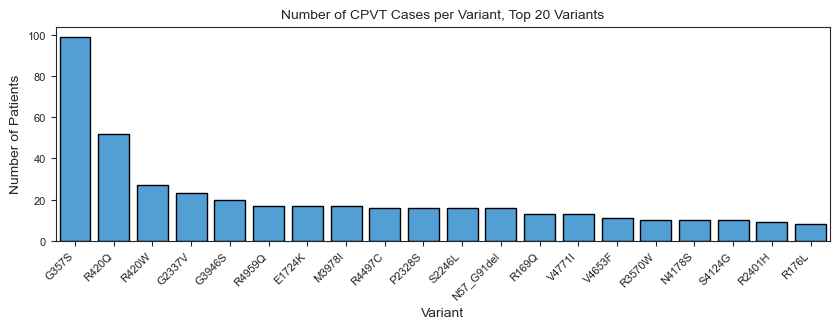

In [10]:
FIG_2_SIZE = (8.5, 3.4)

plt.figure(figsize=FIG_2_SIZE)
sns.barplot(
    data=num_cases_per_variant,
    x="Variant",
    y="Number of Patients",
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
)
# plt.title("Number of CPVT1 Cases per Variant")
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels

set_figure_size(
    "Variant",
    "Number of Patients",
    "Number of CPVT Cases per Variant, Top 20 Variants",
    x_tick_rotation=45,
    x_tick_ha="right",
)

save_current_plot("num_cases_per_variant")

plt.show()

## Variants Per Exon

Number of unique variants per exon

In [11]:
def get_variants_per_exon(df_input: pd.DataFrame):
    unique_by_variant = df_input.drop_duplicates(
        subset=["variant_id"]
    )

    unique_by_variant = unique_by_variant[
        unique_by_variant["exon_start"].notna() & (
                unique_by_variant["exon_start"] + 1 == unique_by_variant[
            "exon_end"]
        )
        ]["exon_start"].value_counts().reset_index().sort_values(
        by=["count"], ascending=False
    )
    unique_by_variant["exon_start"] = unique_by_variant["exon_start"].astype(
        int)

    return unique_by_variant


variant_per_exon = get_variants_per_exon(df_cpvt)
variant_per_exon.head()

,exon_start,count
0,90,43
1,47,12
2,8,10
3,14,9
4,94,8


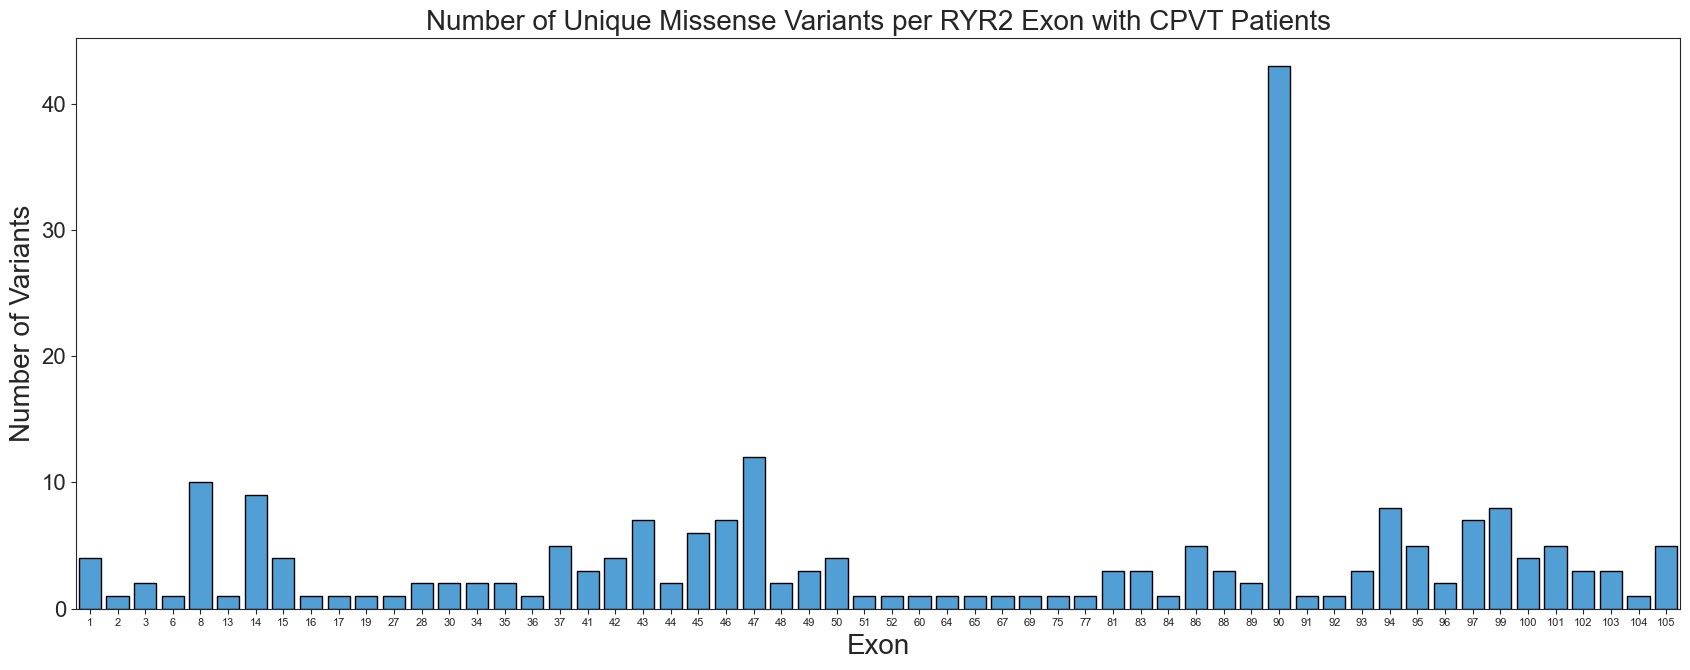

In [12]:
plt.figure(figsize=(
    FIG_2_SIZE[0] * 2, FIG_2_SIZE[1] * 2))  # Double the width and height

# y exons with more than 0 variants
plt_vars = variant_per_exon[variant_per_exon["count"] > 0]

sns.barplot(
    data=variant_per_exon,
    x="exon_start",
    y="count",
    # palette="pastel",
    # hue='hue',
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
    order=plt_vars["exon_start"].sort_values(),
)

set_figure_size(
    "Exon",
    "Number of Variants",
    "Number of Unique Missense Variants per RYR2 Exon with CPVT Patients",
    # double the font size
    x_label_fontsize=20,
    y_label_fontsize=20,
    title_fontsize=20,
    y_tick_fontsize=16,
)

save_current_plot("num_variants_per_exon")

plt.show()

In [13]:
# print number of exons
len(variant_per_exon)

58